In [16]:
from os.path import join,expanduser
import sys
import cmocean as cmo
# identify user's home directory
user_home_dir = expanduser('~')
# import the ECCOv4 py library 
sys.path.insert(0,join(user_home_dir,'ECCOv4-py'))
import ecco_v4_py as ecco
import botocore
import boto3
from boto3.session import Session
import cmocean
from collections import Counter
from dask.distributed import Client
import datetime
import fsspec
from gc import get_referents
import json
from matplotlib import colors as mcolors
from matplotlib.cm import ScalarMappable
import numpy as np
from pathlib import Path
from pprint import pprint
import requests
import s3fs
import sys
from sys import getsizeof
import time as time
from types import ModuleType, FunctionType
import xarray as xr
import matplotlib.pyplot as plt
import zarr
# Use this for the netcdf files stored on an s3 bucket

In [17]:
def get_credentials(use_earthdata=False):
    """
    This routine automatically pulls your EDL crediential from .netrc file and use it to obtain an AWS S3 credential 
    through a PO.DAAC service accessible at https://archive.podaac.earthdata.nasa.gov/s3credentials.
    From the PO.DAAC Github (https://podaac.github.io/tutorials/external/July_2022_Earthdata_Webinar.html).
    
    Returns:
    =======
    
    credentials: a dictionary with AWS secret_key, access_key, and token
    """
    # NASA EarthData hosts ECCO V4r4 fileds
    if use_earthdata == False:
        session = boto3.Session()
        credentials_b3 = session.get_credentials()
        creds_b3 = credentials_b3.get_frozen_credentials()

        credentials = dict()
        credentials['secretAccessKey'] = credentials_b3.secret_key
        credentials['accessKeyId'] = credentials_b3.access_key
        credentials['sessionToken'] = credentials_b3.token

    # A 'public' AWS s3 bucket hosts V4r5 fields (they will eventually move to PO.DAAC)
    else:
        credentials = requests.get('https://archive.podaac.earthdata.nasa.gov/s3credentials').json()

    return credentials


In [18]:
def init_S3FileSystem(use_earthdata=False, requester_pays=True):
    """
    This routine automatically creates an 's3 file system' object and credentials dictionary.
    The s3 file system needs to be initialized with the special aws credentials.
    
    Returns:
    =======
    
    s3: an AWS S3 filesystem, 
    credentials: a dictionary with AWS secret_key, access_key, and token

    """
    credentials = get_credentials(use_earthdata=use_earthdata)

    if use_earthdata:
        requester_pays = False

    s3 = s3fs.S3FileSystem(requester_pays=requester_pays,
                           anon=False,
                           key=credentials['accessKeyId'],
                           secret=credentials['secretAccessKey'],
                           token=credentials['sessionToken'])

    return s3, credentials
BLACKLIST = type, ModuleType, FunctionType


In [19]:
def getsize(obj):
    """
    This routine returns the in-memory size of an python object
    
    Returns:
    =======
    
    size: size of object & members.
    """
    if isinstance(obj, BLACKLIST):
        raise TypeError('getsize() does not take argument of type: '+ str(type(obj)))
    seen_ids = set()
    size = 0
    objects = [obj]
    while objects:
        need_referents = []
        for obj in objects:
            if not isinstance(obj, BLACKLIST) and id(obj) not in seen_ids:
                seen_ids.add(id(obj))
                size += sys.getsizeof(obj)
                need_referents.append(obj)
        objects = get_referents(*need_referents)
    return size


In [20]:
##1. Access the monthly files and create the monthly climatologies
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))
monthly = [[] for _ in range(12)]
tilesel = 0
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    #ds_tile0 = ds.sel(tile=tilesel) # Select only tile 0 and drop tile dimension
    monthly[month_idx].append(ds)

##============================== 2. Do the TEMP climatology for every month ================================
climon    = []
for i in range(0,12):
  print("I am in month",i)
  var     = monthly[i]
  mon_all = xr.concat(var, dim ='time')
  monclim = mon_all.mean(dim ='time',skipna ="True")
  climon.append(monclim)


I am in month 0
I am in month 1
I am in month 2
I am in month 3
I am in month 4
I am in month 5
I am in month 6
I am in month 7
I am in month 8
I am in month 9
I am in month 10
I am in month 11


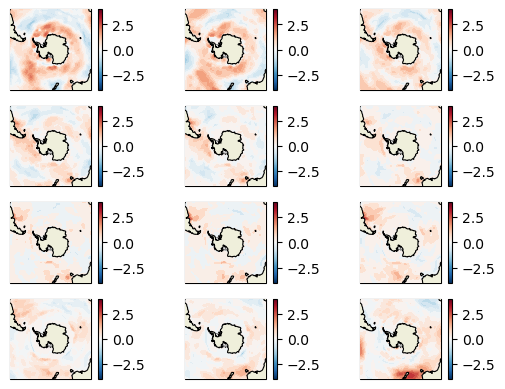

In [22]:
## 2. Create 2D maps of monthly temperature anomaly around the southern ocean for a given year ##
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
y         = 2017
ecco_v4r5_mon_mean_native_dataset_paths2 = np.sort(list(directory.glob(f'*{y}-*.nc')))
mon       = [[] for _ in range(12)]
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths2):
    ds        = xr.open_dataset(file_path);
    month_idx = int(ds.time.dt.month.item()) - 1 # Extract month (1–12), convert to index (0–11)
    mon[month_idx].append(ds)
### TEMPERATURE ANOMALIES ##
anomon      = []
for i in range(0,12):
   var      = mon[i][0].THETA[0,:,:,:,:]
   climvar  = climon[i].THETA[:,:,:,:]
   TEMPANOM = var - climvar ##the i loops in the months 
   anomon.append(TEMPANOM)
##------ PLOT THE TEMPERATURE ANOMALY of all months------------------------------------------
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
nrow      = 4;ncol =3;figca      = []
colorm    = cmocean.cm.balance
cmin      = -2;cmax = 2;cstep = 1
for a in range(0,12):
  var  = anomon[a][0,:,:,:]
  #  ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var,user_lon_0=-66,projection_type='cyl',plot_type = 'pcolormesh', dx=.25,dy=.25,ax=axis[a],cmin=cmin,cmax=cmax,colormap=colorm,show_coastline=True,subplot_grid=[nrow, ncol, a+1],show_colorbar=True) ## this is the Plat Carree
  ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var, projection_type='stereo',plot_type = 'contourf', show_colorbar=True,dx=1, dy=1,lat_lim=-40,cmin=-4,cmax=4,colormap=colorm,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a+1]);
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/SO_TEMPANOM_{y}_2D.png')



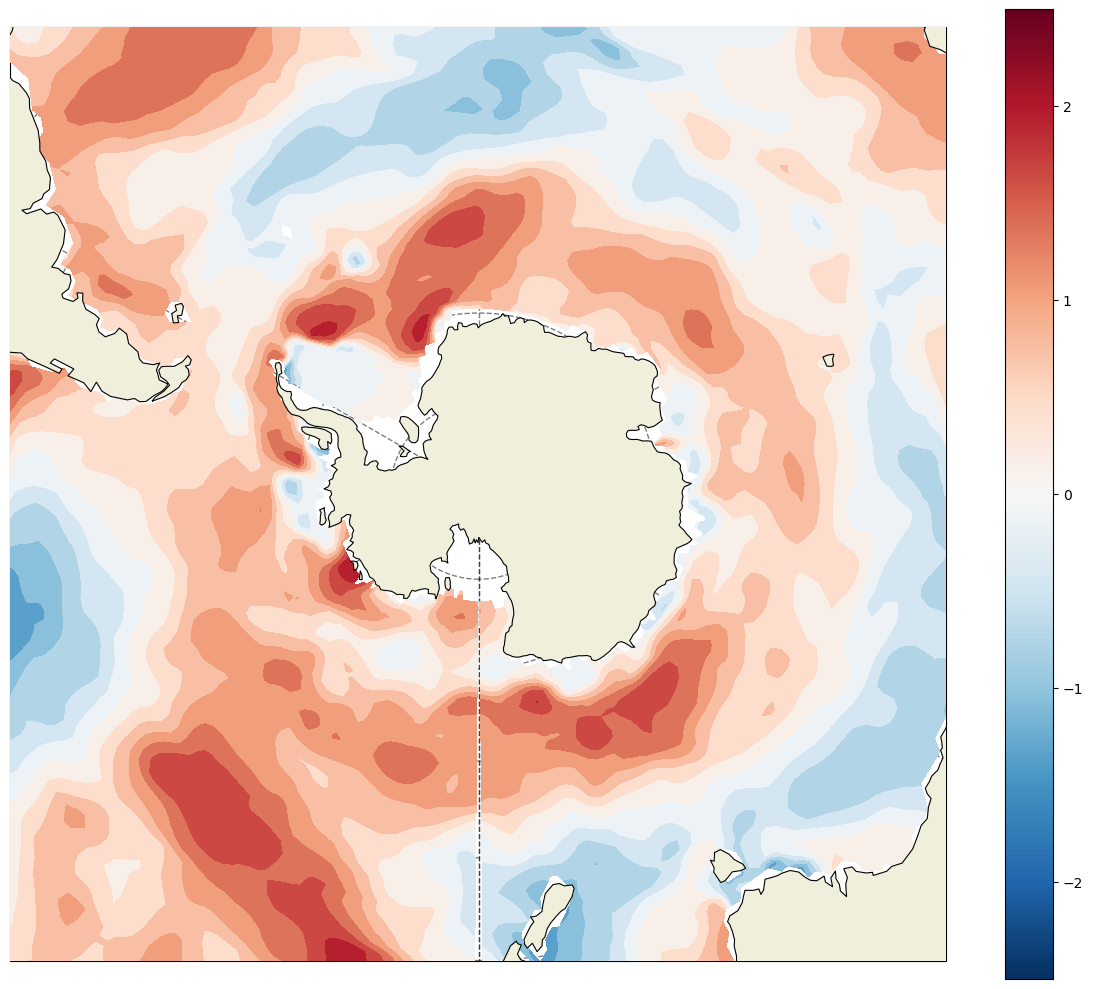

In [8]:
## 3.Plot the monthly Temp Anom of February 2017 in the SO ##
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
colorm    = cmocean.cm.balance
fig    = plt.figure(figsize=(12, 10))
nrow   = 1;ncol=1;a=1
cmin   = -2.5;cmax =2.5;cstep=0.5;
levels = np.arange(cmin,cmax+cstep,cstep)
var    = anomon[1][0,:,:,:]
ca     = ecco.plot_proj_to_latlon_grid(var.XC, var.YC, var, projection_type='stereo',plot_type = 'contourf',dx=1, dy=1,lat_lim=-40,cmin=cmin,cmax=cmax,levels=levels,colormap=colorm,show_colorbar=True,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a]);
plt.tight_layout()
plt.savefig('/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/SO_TEMPANOM_FEB2017_2D.png',dpi=300,bbox_inches='tight' )


I am in tile 0
I am in tile 1
I am in tile 2
I am in tile 3


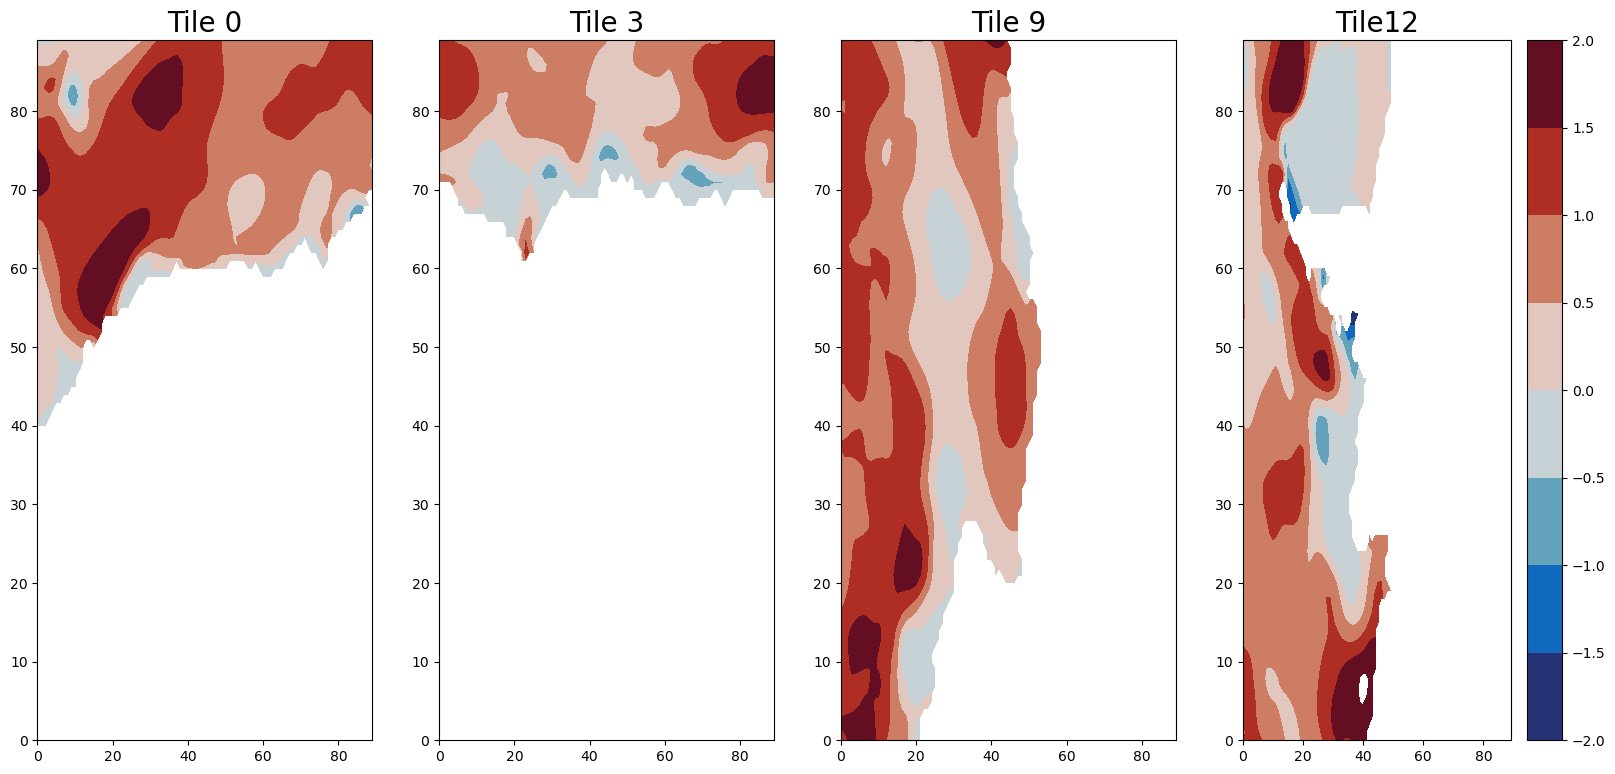

In [11]:
### 4. Extract Tiles 0,3,9,12 around the SO and plot the Feb. temperature anomaly of each tile 
colorm   = cmocean.cm.balance
nrow     = 1;ncol  =4;figca      = []
cmin     = -2;cmax =2;cstep=0.5
fig, axs = plt.subplots(nrow,ncol,figsize=(22,14))
plt.subplots_adjust(left=0.1,bottom=0.3, right=0.8, top=0.8, wspace=0.2, hspace=0.1)
axis     = fig.axes;taxis = [0,3,9,12]
titles   = ["Tile 0","Tile 3","Tile 9","Tile12"]
for t in range(0,len(taxis)):
  print("I am in tile",t)
  meanT = anomon[1][0,taxis[t],:,:] ## 1 for January
  ca    = axis[t].contourf(meanT,levels = np.arange(cmin,cmax+cstep,cstep),cmap = colorm);
  axis[t].set_title(titles[t],fontsize=20)
fig.colorbar(ca,ax=axis[3]);
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/SO_TILES.png')

In [11]:
##5. Check dimensions of monthly climatology file
climon[0]

<xarray.Dataset> Size: 47MB
Dimensions:  (k: 50, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, k_u: 50,
              k_l: 50, k_p1: 51, nb: 4, nv: 2)
Coordinates: (12/20)
  * i        (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g      (i_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j        (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g      (j_g) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * k        (k) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
  * k_u      (k_u) int32 200B 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
    ...       ...
    Zp1      (k_p1) float32 204B 0.0 -10.0 -20.0 ... -5.678e+03 -6.134e+03
    Zu       (k_u) float32 200B -10.0 -20.0 -30.0 ... -5.678e+03 -6.134e+03
    Zl       (k_l) float32 200B 0.0 -10.0 -20.0 ... -5.244e+03 -5.678e+03
    XC_bnds  (tile, j, i, nb) float32 2MB -115.0 -115.0 -107.9 ... -115.0 -108.5
    YC_bnds  (tile, j, i, nb) float32 2MB -88.18 -88.32 -88.3 ... -88.18 -88.16
    Z_bnds   (k, nv) float32 400B 0.0 -10.0 -10.0 ... -5.678e+03 -6.134e+03
Dimensions without coordinates: nb, nv
Data variables:
    THETA    (k, tile, j, i) float32 21MB nan nan nan nan ... nan nan nan nan
    SALT     (k, tile, j, i) float32 21MB nan nan nan nan ... nan nan nan nan

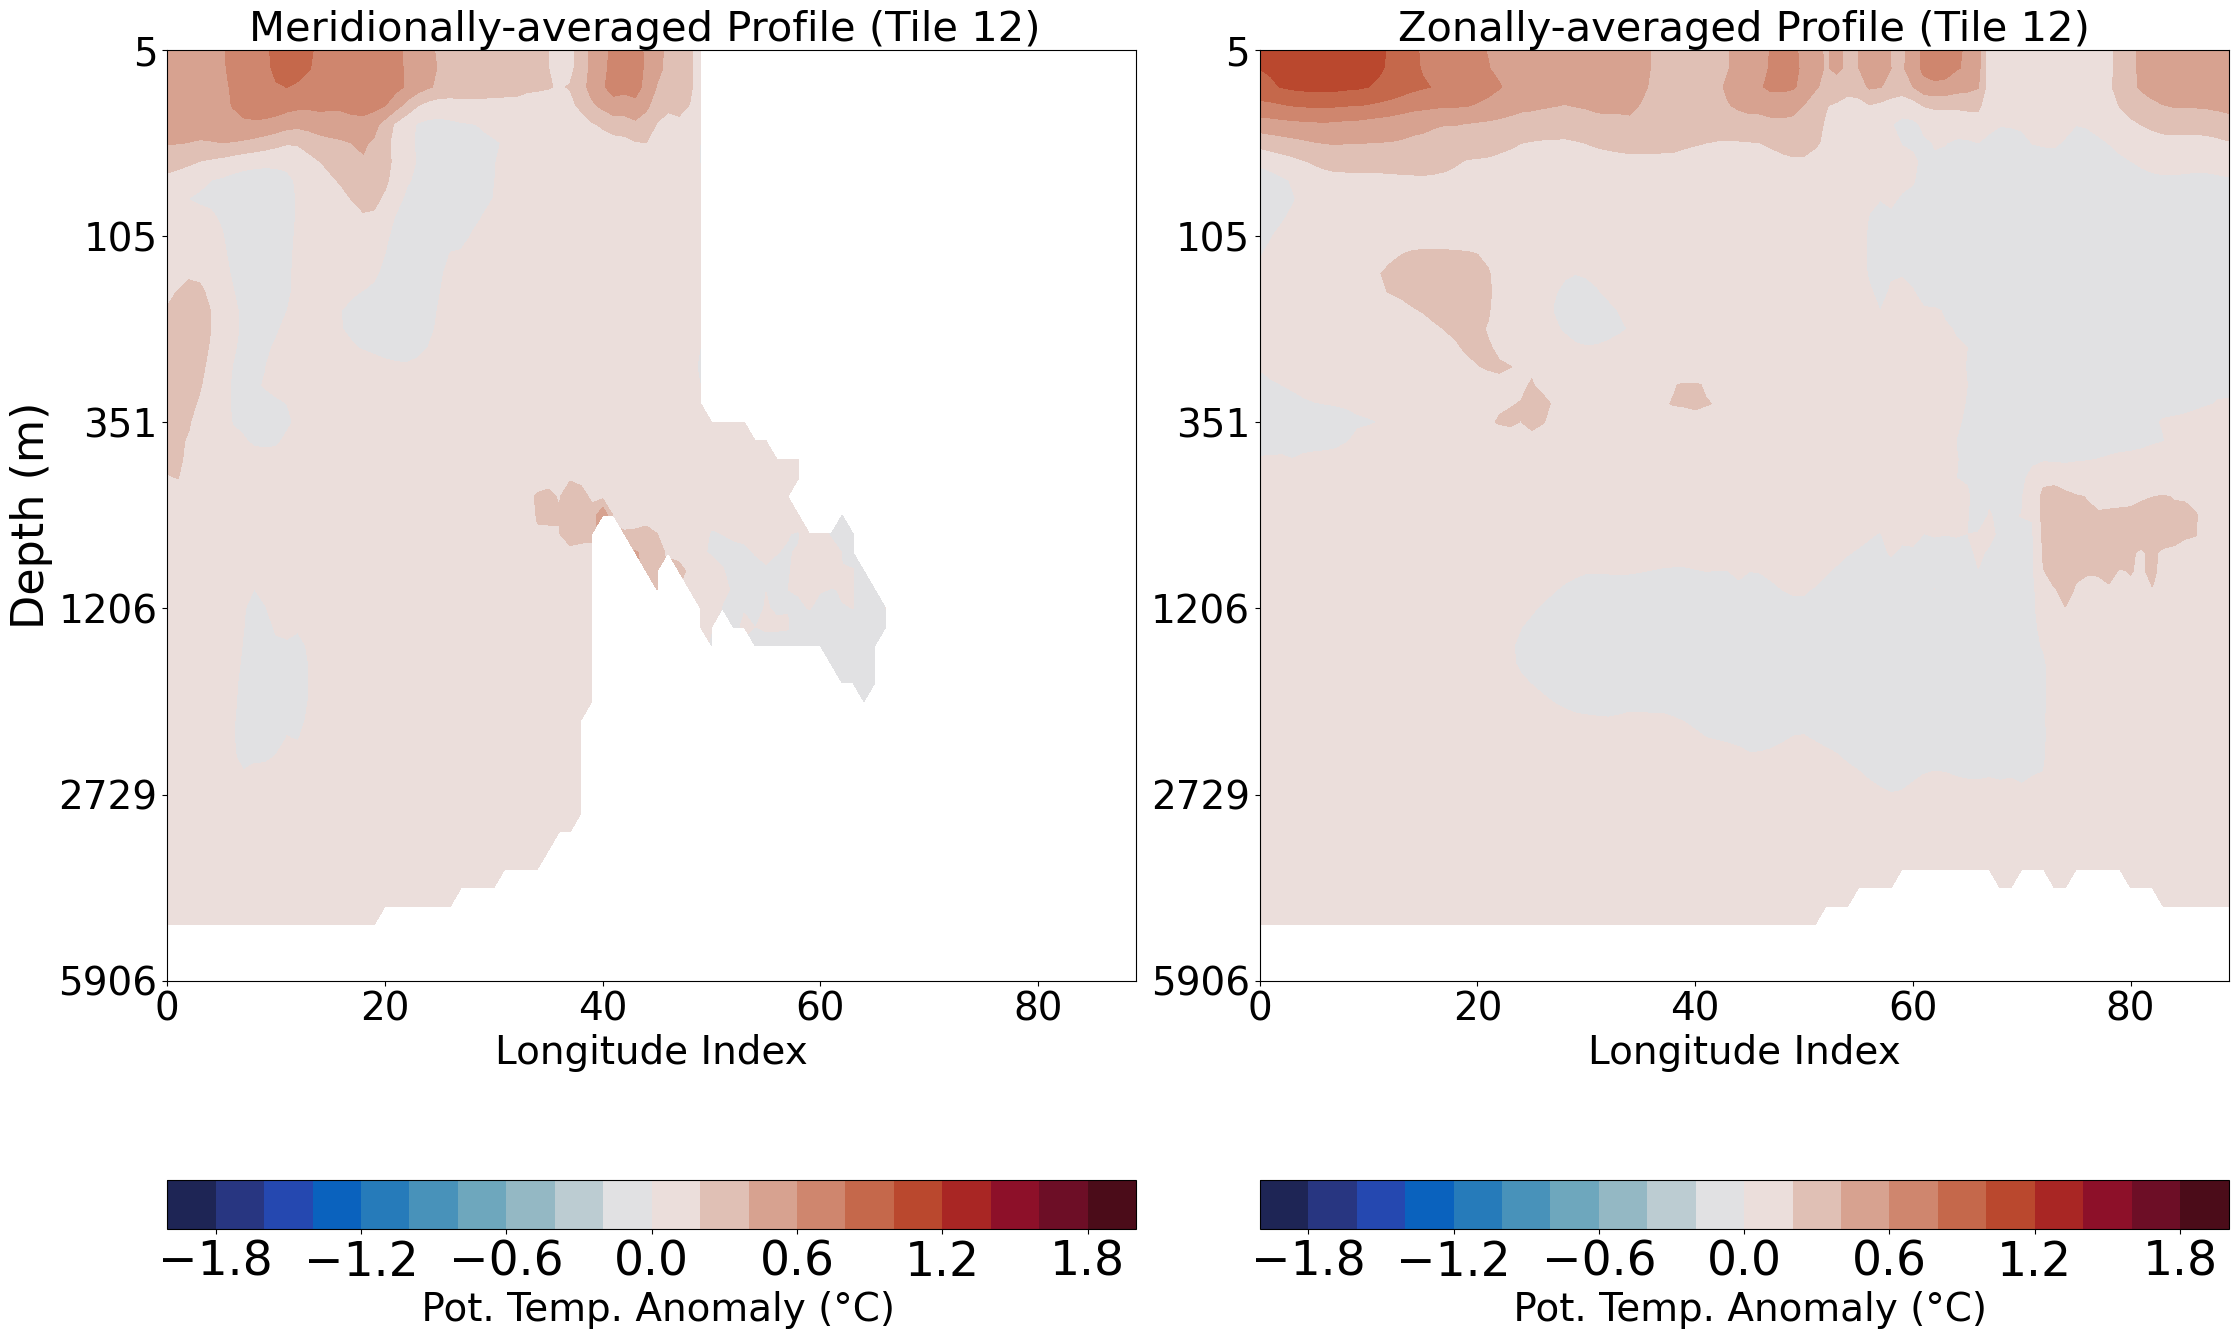

In [12]:
#6. Extract and plot the meridionally- and zonally-averaged temperature anomaly for each tile around the SO
t            = 12##choose tile
febclimy     = climon[1].THETA[:, t, :, :].mean(dim="j", skipna=True)
febclimx     = climon[1].THETA[:, t, :, :].mean(dim="i", skipna=True)
febtempy     = mon[1][0].THETA[0,:,t,:,:].mean(dim="j", skipna=True)
febtempx     = mon[1][0].THETA[0,:,t,:,:].mean(dim="i", skipna=True)
febtempanomy = febtempy - febclimy
febtempanomx = febtempx - febclimx
var2         = [febtempanomy,febtempanomx]
depth        = febclimy.coords["Z"].values;depth_m   = -depth                           # [5, 15, …]
titles       = [f"Meridionally-averaged Profile (Tile {t}) ",f"Zonally-averaged Profile (Tile {t})"]
nrow     = 1;ncol = 2
fig, axs = plt.subplots(nrow,ncol,figsize=(22,14));axis     = fig.axes
cmin     = -2;cmax=2;cstep=0.2
for a in range(0,2): ## loop through the plots
   cs      = axis[a].contourf(var2[a], cmap=colorm,levels=np.arange(cmin,cmax+cstep,cstep))
   axis[a].invert_yaxis()
   yticks  = axis[a].get_yticks();  inds = np.clip(yticks.astype(int), 0, len(depth_m)-1)
   ylabels = depth_m[inds] # 7) Look up the real depths at those indices
   axis[a].set_yticks(yticks);axis[a].set_yticklabels(np.round(ylabels).astype(int))
   axis[a].set_xlabel('Longitude Index',fontsize=28);
   axis[a].tick_params(axis='both', which='major', labelsize=28)
   axis[a].set_title(titles[a],fontsize=30,loc="center")
   cbar    = fig.colorbar(cs, ax=axis[a], orientation='horizontal') ##COLORBAR 
   cbar.set_label(' Pot. Temp. Anomaly (°C)',fontsize=28)
   cbar.ax.tick_params(axis='x', which='major', labelsize=34)
   plt.tight_layout()
axis[0].set_ylabel('Depth (m)',fontsize=32)
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/MER_ZON_TEMPANOM_FEB2017_TILE{t}.png')

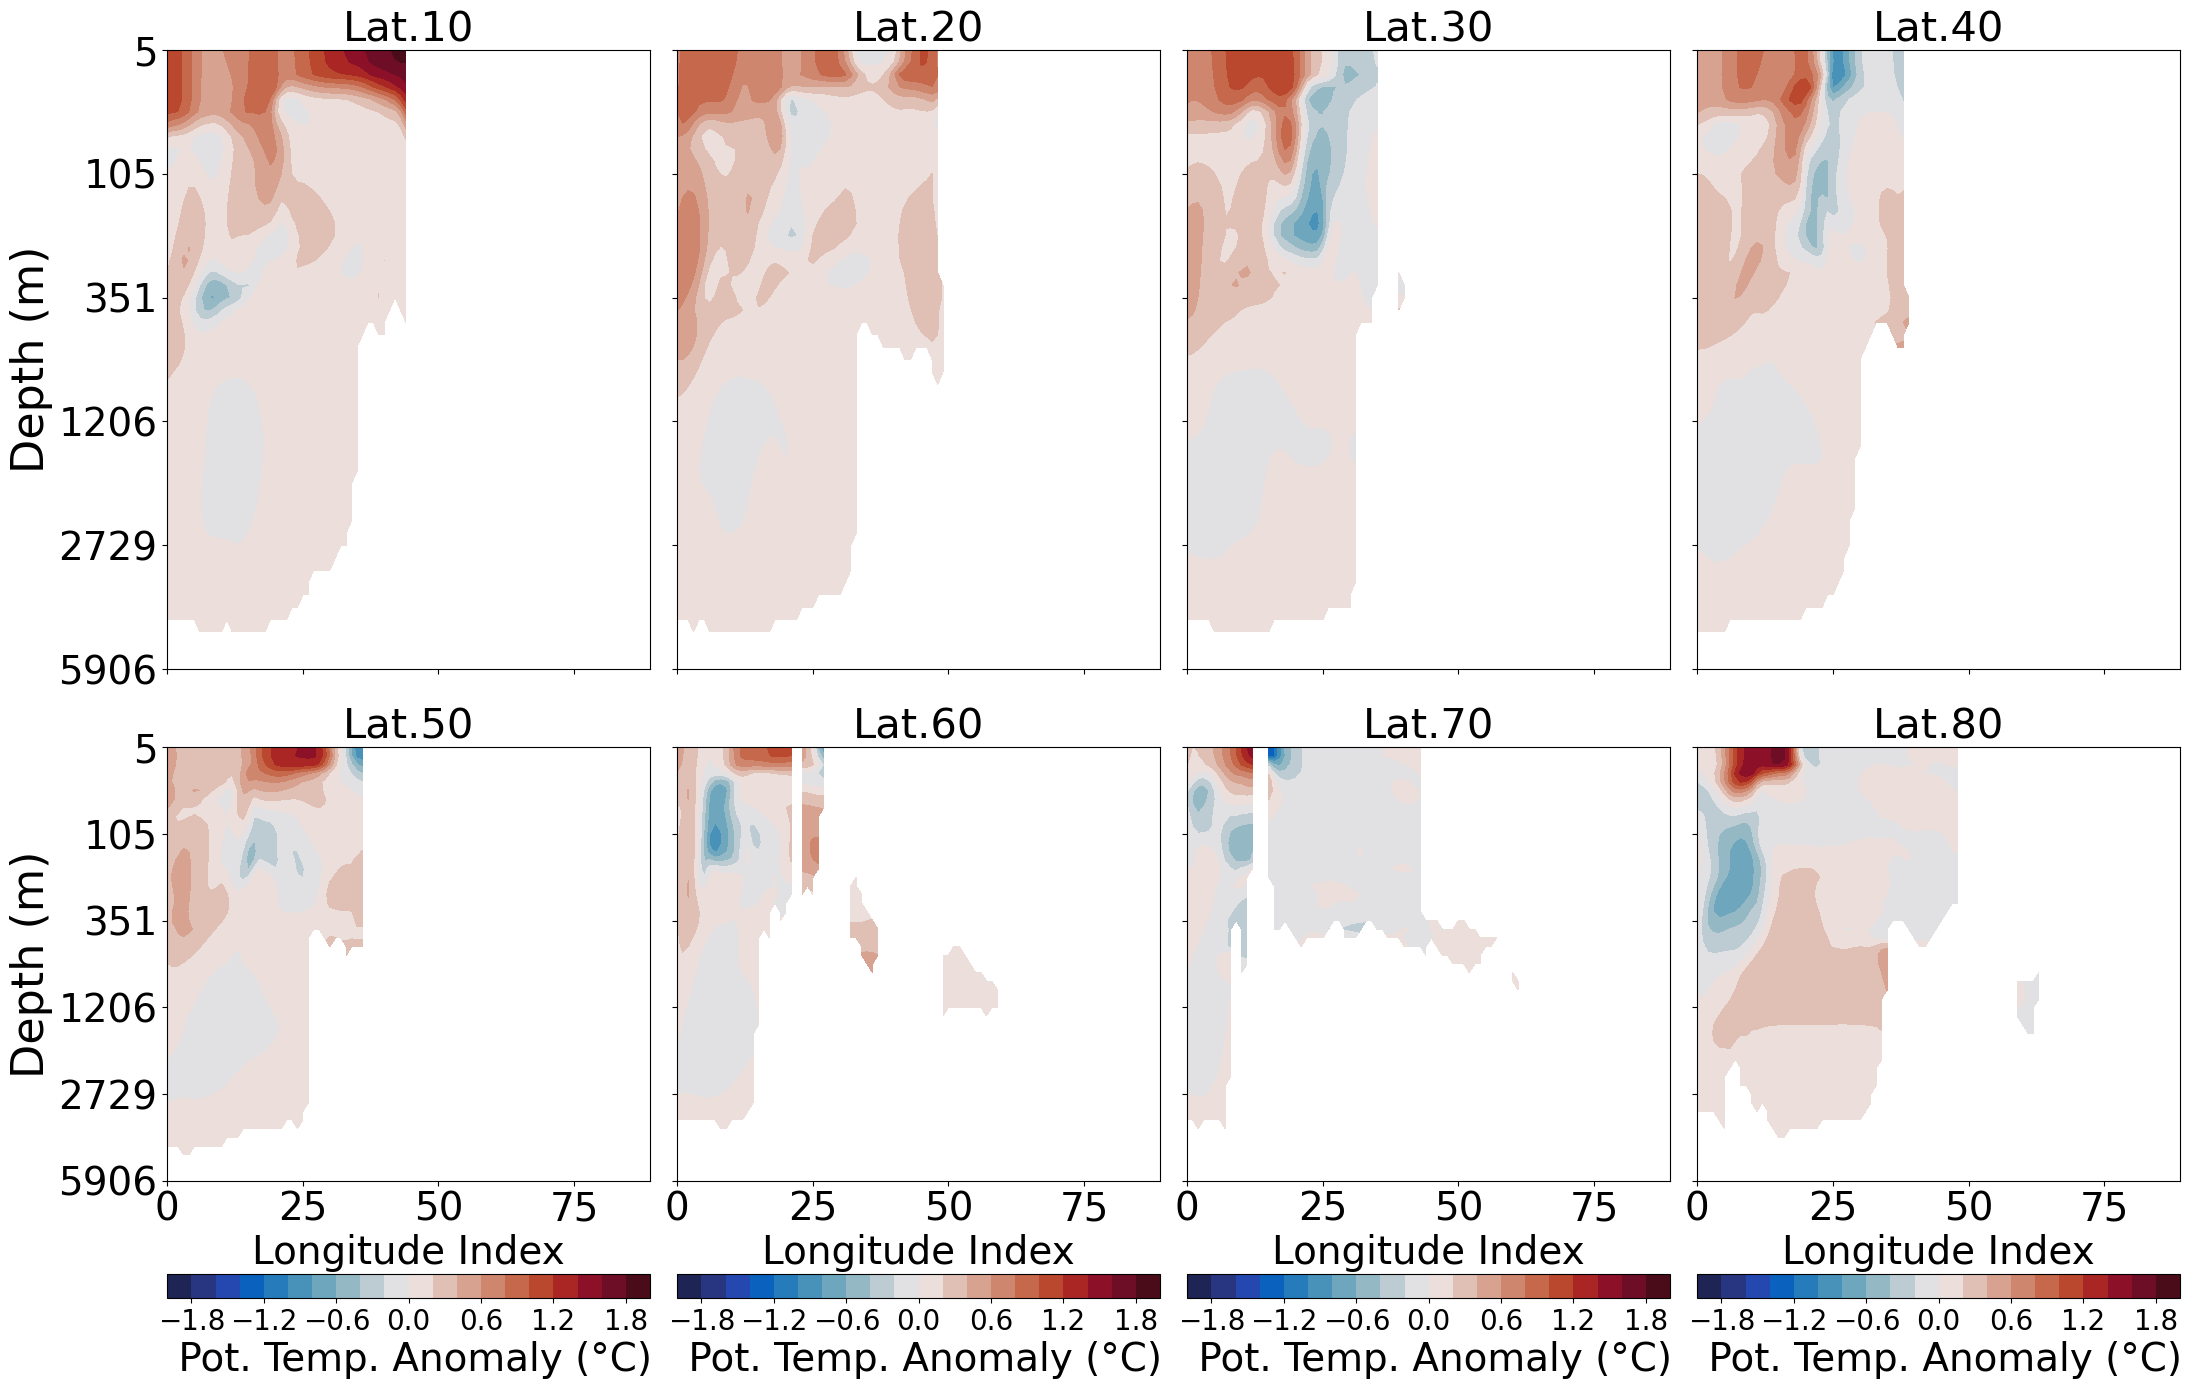

In [14]:
#7. Extract and plot zonal transects of temperature anomalies of each tile around the Southern Ocean
tile     = 12; ##choose tile
latit    =[10,20,30,40,50,60,70,80] ##choose latitude
nrow     = 2;ncol = 4
fig, axs = plt.subplots(nrow,ncol,figsize=(22,14),sharey=True,sharex=True);axis     = fig.axes
colorm   = cmocean.cm.balance;
cmin     = -2;cmax=2;cstep=0.2
for l in range(0,8):
   cs      = axis[l].contourf(anomon[1][:,tile,latit[l],:], cmap=colorm,levels = np.arange(cmin,cmax+cstep,cstep))
   yticks  = axis[l].get_yticks();  inds = np.clip(yticks.astype(int), 0, len(depth_m)-1)
   ylabels = depth_m[inds] # 7) Look up the real depths at those indices
   axis[l].set_yticks(yticks);axis[l].set_yticklabels(np.round(ylabels).astype(int))
   axis[l].tick_params(axis='both', which='major', labelsize=28)
   axis[l].set_title(f"Lat.{latit[l]}",fontsize = 30,loc="center")
   if l in [0, 4]:  # Show y-axis labels only on 1st and 5th
      axis[l].set_ylabel('Depth (m)', fontsize=32)
   if l>3:
     cbar  = fig.colorbar(cs, ax=axis[l], orientation='horizontal') ##COLORBAR
     cbar.set_label(' Pot. Temp. Anomaly (°C)',fontsize=28)
     cbar.ax.tick_params(axis='x', which='major', labelsize=20)
     axis[l].set_xlabel('Longitude Index',fontsize=28)
   plt.tight_layout()
axis[0].invert_yaxis()
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/ZONAL_TRANSECT_TEMPANOM_FEB2017_TILE{tile}.png')

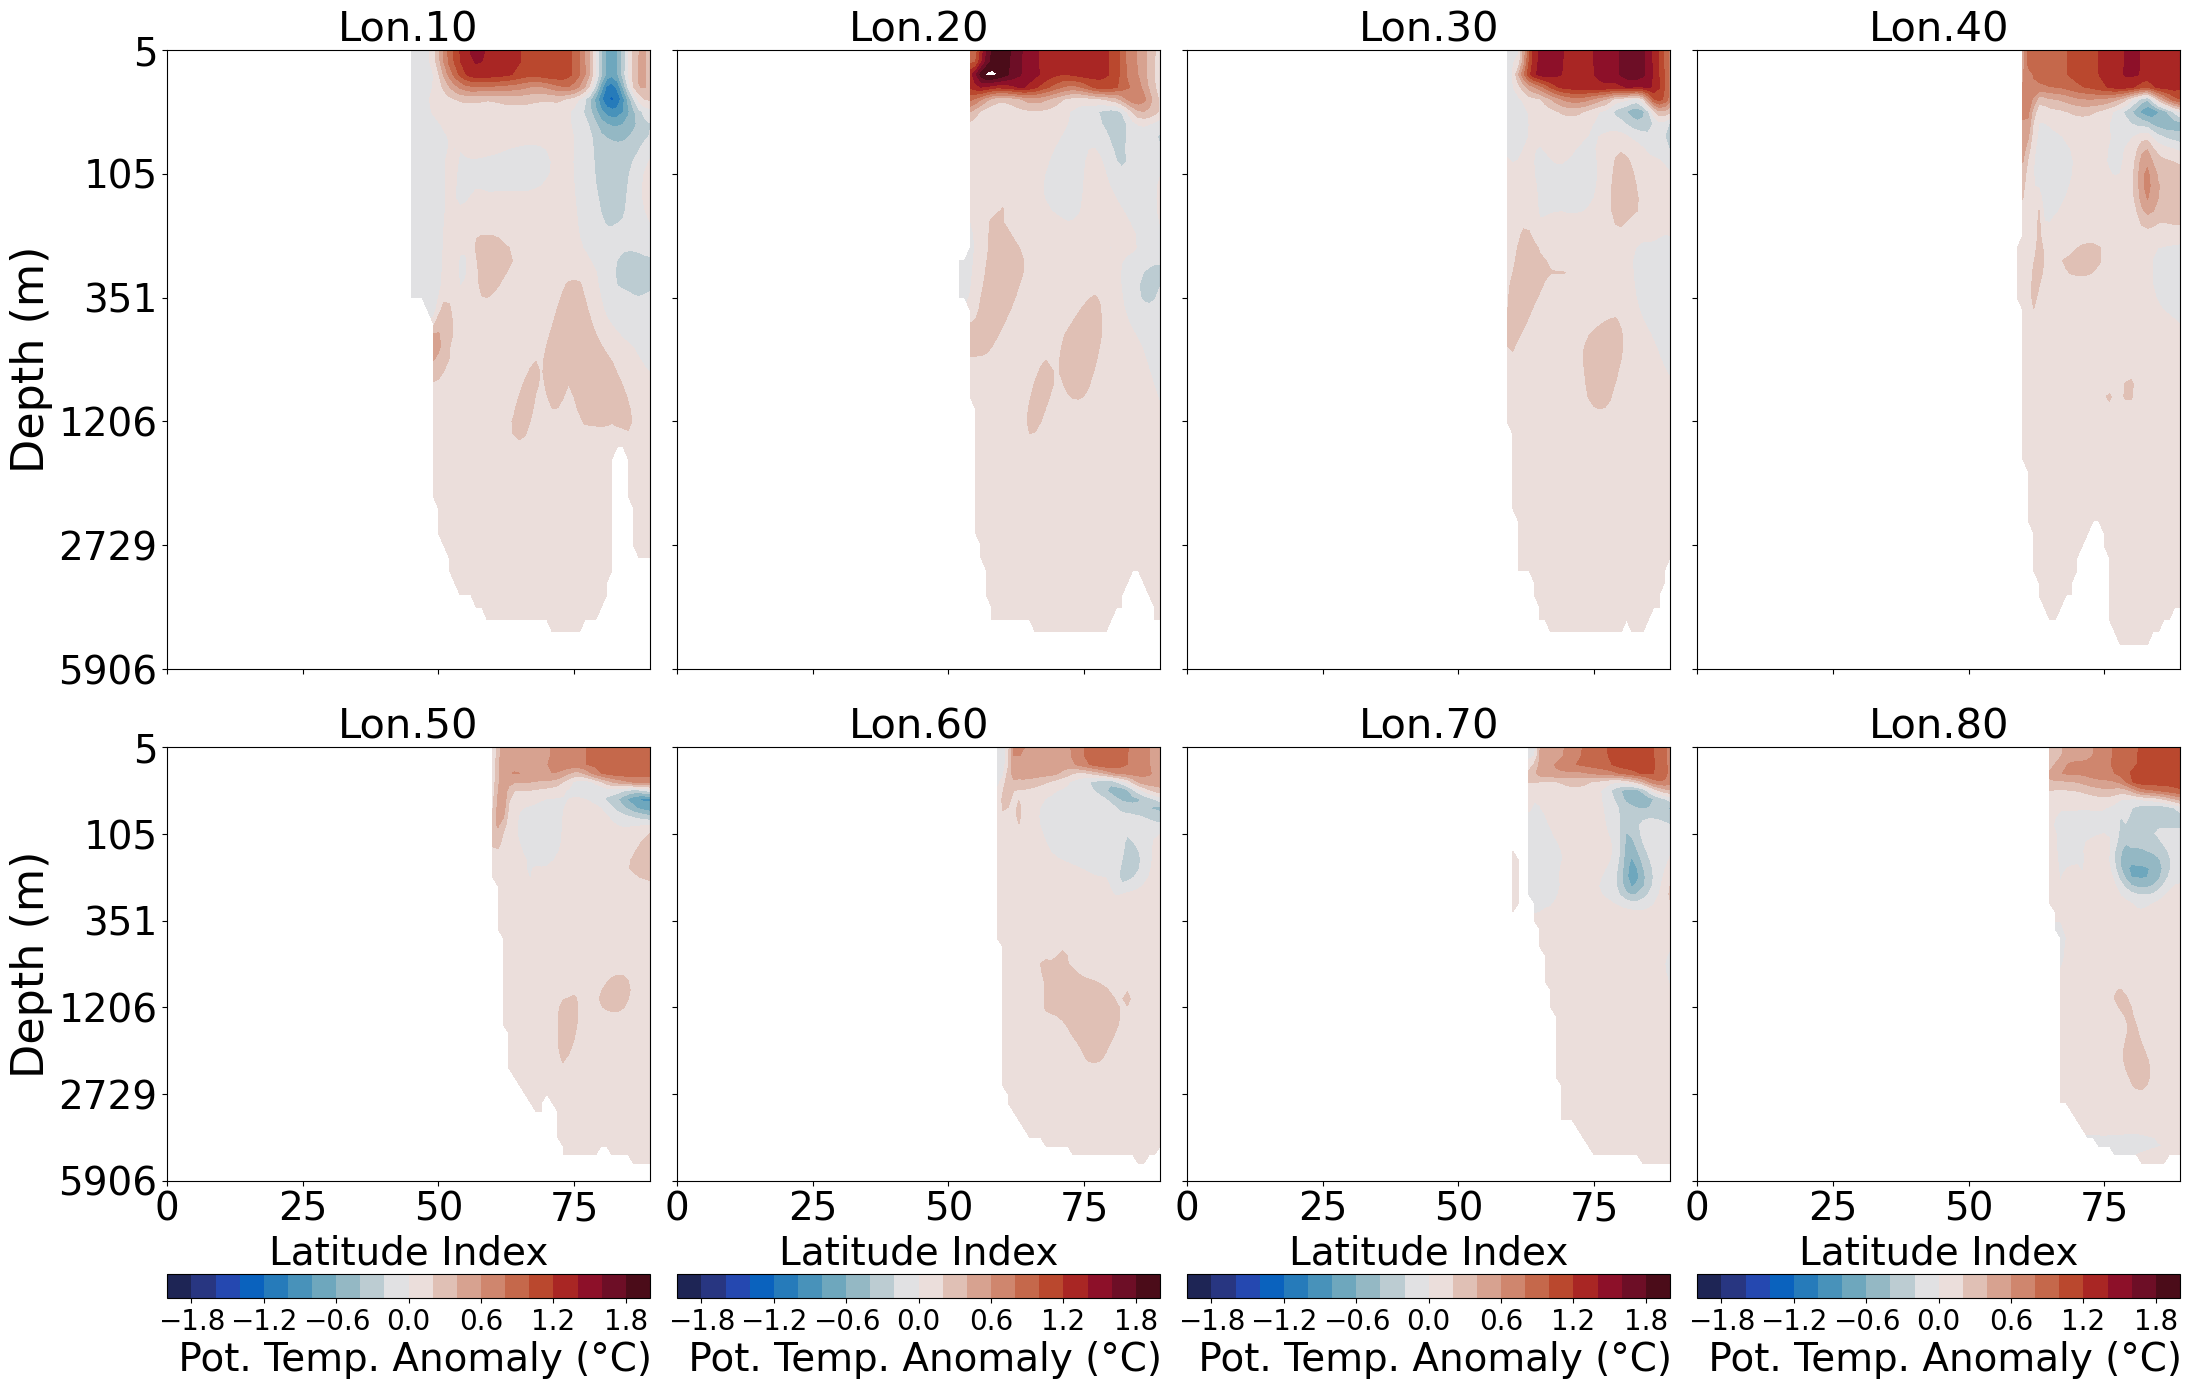

In [15]:
#8. Extract and plot meridional transects of tile around the SO 
depth    = anomon[1].coords["Z"].values;depth_m   = -depth
tile     = 0; ##choose tile
longit   =[10,20,30,40,50,60,70,80] #choose longitude
nrow     = 2;ncol = 4
fig, axs = plt.subplots(nrow,ncol,figsize=(22,14),sharey=True,sharex=True);axis     = fig.axes
colorm   = cmocean.cm.balance;
cmin     = -2;cmax=2;cstep=0.2
for l in range(0,8):
  cs      = axis[l].contourf(anomon[1][:,tile,:,longit[l]], cmap=colorm,levels = np.arange(cmin,cmax+cstep,cstep))
  yticks  = axis[l].get_yticks();  inds = np.clip(yticks.astype(int), 0, len(depth_m)-1)
  ylabels = depth_m[inds] # 7) Look up the real depths at those indices
  axis[l].set_yticks(yticks);axis[l].set_yticklabels(np.round(ylabels).astype(int))
  axis[l].tick_params(axis='both', which='major', labelsize=28)
  axis[l].set_title(f"Lon.{longit[l]}",fontsize=30,loc="center")
  if l in [0, 4]:  # Show y-axis labels only on 1st and 5th
     axis[l].set_ylabel('Depth (m)', fontsize=32)
  if l>3:
    cbar  = fig.colorbar(cs, ax=axis[l], orientation='horizontal') ##COLORBAR
    cbar.set_label(' Pot. Temp. Anomaly (°C)',fontsize=28)
    cbar.ax.tick_params(axis='x', which='major', labelsize=20)
    axis[l].set_xlabel('Latitude Index',fontsize=28)
  plt.tight_layout()
axis[0].invert_yaxis()
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMPANOM/MERIDIONAL_TRANSECT_TEMPANOM_FEB2017_TILE{tile}.png')

In [27]:
##9. Open again the temperature data of ECCOV4/r5 to compute the temperature trend over the years
directory = Path('/home/jovyan/efs_ecco/ECCO/V4/r5/netcdf/native/mon_mean/OCEAN_TEMPERATURE_SALINITY')
# list sub-directories (one per dataset) 1992 - 2019
ecco_v4r5_mon_mean_native_dataset_paths = np.sort(list(directory.glob('*')))


In [28]:
##10.Extract the upper 50m of temperature of all years 
arrs      = []
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds    = xr.open_dataset(file_path);
    top50 = ds['THETA'].isel(k=slice(0, 6)).mean(dim='k')  # (tile, j, i)
    arrs.append(top50)                 

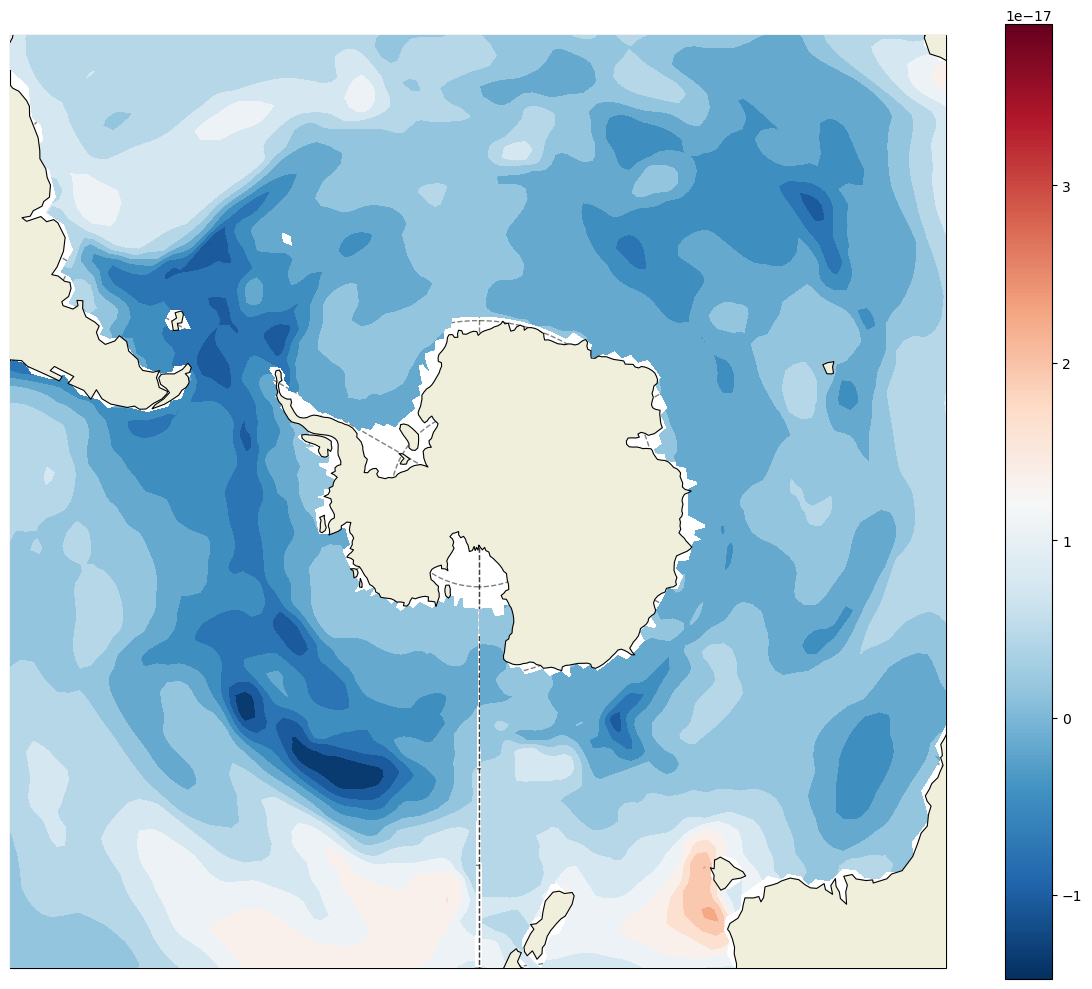

In [30]:
##11. Now plot the temperature trend around the SO for the upper 50 layers, over 1992-2019
arrs      = []
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds    = xr.open_dataset(file_path);
    top50 = ds['THETA'].isel(k=slice(0, 6)).mean(dim='k')  # (tile, j, i)
    arrs.append(top50)
all_t       = xr.concat(arrs, dim='time')
## Compute the linear trend
fit         = all_t.polyfit(dim='time', deg=1)
slope_month = fit['polyfit_coefficients'].sel(degree=1)# Extract the slope (degree = 1) — this is °C per index (month)
trend       = slope_month * 12# Convert to °C per year (monthly → yearly)
##--------- Plot the Temp Anom of 2017 -------------
montitles   = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
colorm      = cmocean.cm.balance
fig         = plt.figure(figsize=(12, 10))
nrow =1;ncol=1;a=1
#cmin = -2.5;cmax=2.5;cstep=0.5; levels = np.arange(cmin,cmax+cstep,cstep)
ca  = ecco.plot_proj_to_latlon_grid(all_t.XC, all_t.YC, trend, projection_type='stereo',plot_type = 'contourf',dx=1, dy=1,lat_lim=-40,colormap=colorm,show_colorbar=True,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a]);
plt.tight_layout()
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMP_ABS_TREND/TEMP_TREND_SO_0_50_1992_2019.png')

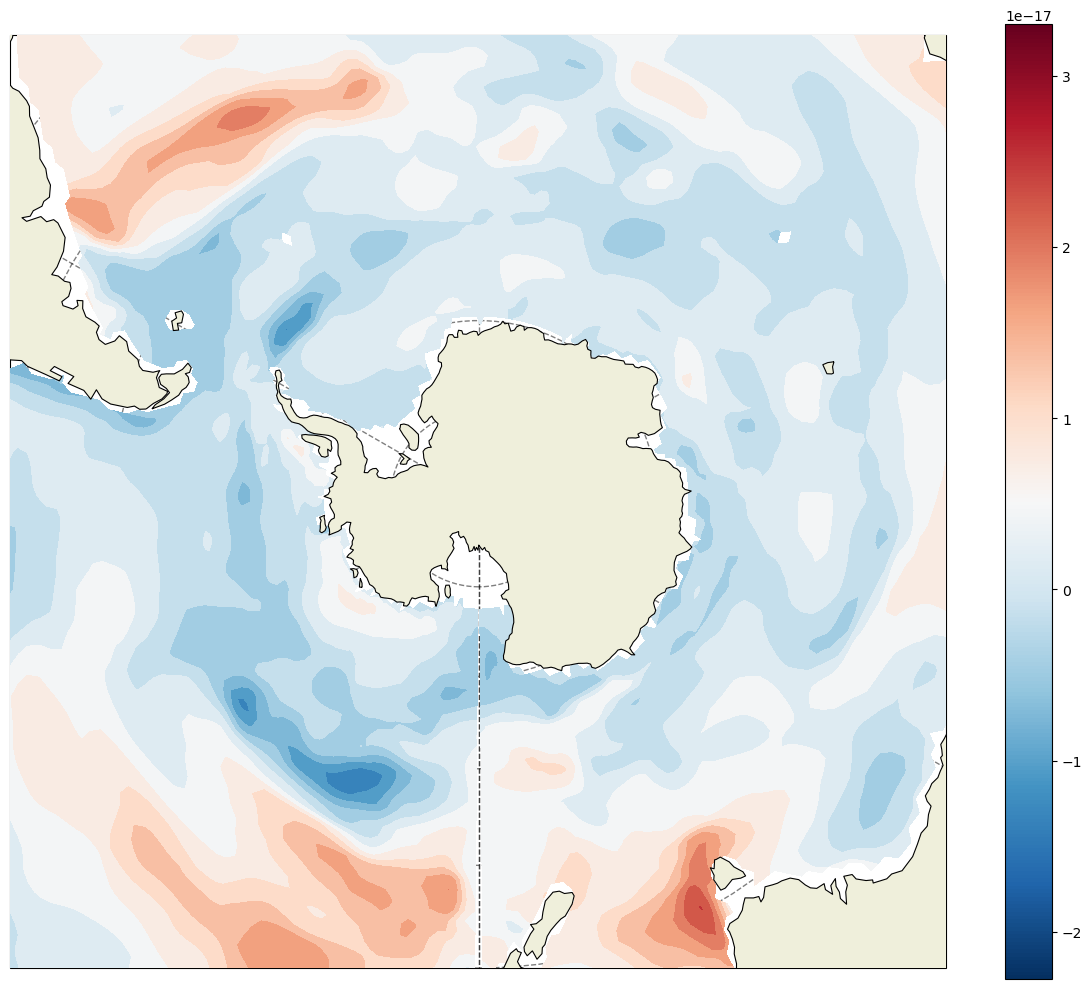

In [31]:
# 12. Extract and plot the temperature trend between 50-222m in the SO, over 1992-2019
arrs     = []
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds    = xr.open_dataset(file_path);
    top50 = ds['THETA'].isel(k=slice(6, 18)).mean(dim='k')  # (tile, j, i)
    arrs.append(top50)
all_t     = xr.concat(arrs, dim='time')
## calculate the linear trend
fit         = all_t.polyfit(dim='time', deg=1)
slope_month = fit['polyfit_coefficients'].sel(degree=1)# Extract the slope (degree = 1) — this is °C per index (month)
trend       = slope_month * 12# Convert to °C per year (monthly → yearly)
## Plot the Temperature (50-222m) trend over 1992-2019
montitles = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
colorm    = cmocean.cm.balance
fig       = plt.figure(figsize=(12, 10))
nrow      = 1;ncol=1;a=1
ca        = ecco.plot_proj_to_latlon_grid(all_t.XC, all_t.YC, trend, projection_type='stereo',plot_type = 'contourf',dx=1, dy=1,lat_lim=-40,colormap=colorm,show_colorbar=True,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a]);
plt.tight_layout()
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMP_ABS_TREND/TEMP_TREND_SO_50_222_1992_2019.png')


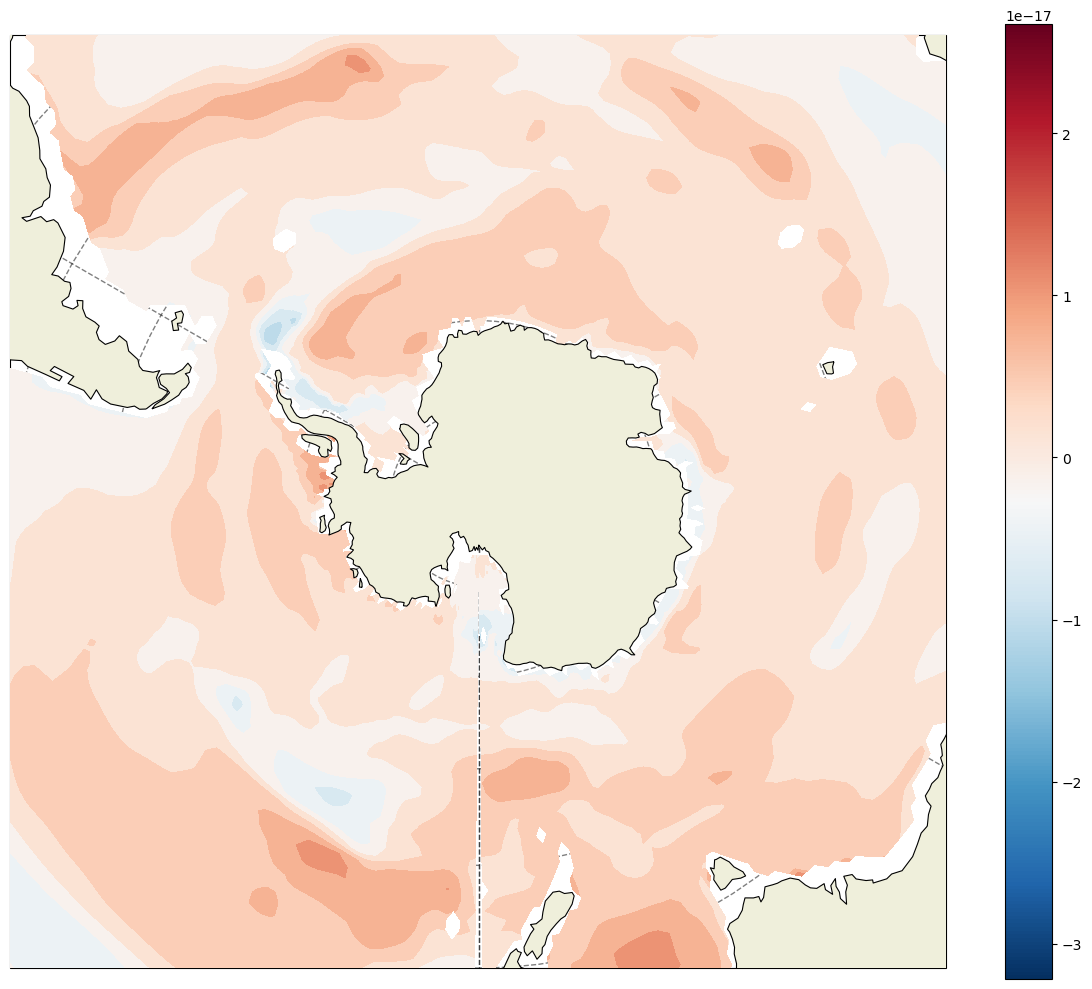

In [41]:
# 13. Extract and plot the temperature trend between 222-722mm in the SO, over 1992-2019
arrs      = []
for i, file_path in enumerate(ecco_v4r5_mon_mean_native_dataset_paths):
    ds    = xr.open_dataset(file_path);
    top50 = ds['THETA'].isel(k=slice(19, 26)).mean(dim='k')  # (tile, j, i)
    arrs.append(top50)
all_t     = xr.concat(arrs, dim='time')
## Compute the linear trend
fit         = all_t.polyfit(dim='time', deg=1)
slope_month = fit['polyfit_coefficients'].sel(degree=1)# Extract the slope (degree = 1) — this is °C per index (month)
trend       = slope_month * 12# Convert to °C per year (monthly → yearly)
## Plot the Temperature (222-722) trend over 1992-2019
montitles   = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]
colorm      = cmocean.cm.balance
fig         = plt.figure(figsize=(12, 10))
nrow        = 1;ncol=1;a=1
ca          = ecco.plot_proj_to_latlon_grid(all_t.XC, all_t.YC, trend, projection_type='stereo',plot_type = 'contourf',dx=1, dy=1,lat_lim=-40,colormap=colorm,show_colorbar=True,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a]);
plt.tight_layout()
plt.savefig(f'/home/jovyan/efs_ecco/sdarma/FIGURES/TEMP_TREND_SO_222_722_1992_2019.png')


In [42]:
#14. Check that the time of the temperature is between 1992-2019
print(all_t.time)

<xarray.DataArray 'time' (time: 336)> Size: 3kB
array(['1992-01-16T18:00:00.000000000', '1992-02-15T12:00:00.000000000',
       '1992-03-16T12:00:00.000000000', ..., '2019-10-16T12:00:00.000000000',
       '2019-11-16T00:00:00.000000000', '2019-12-16T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 3kB 1992-01-16T18:00:00 ... 2019-12-16
Attributes:
    axis:                   T
    bounds:                 time_bnds
    comment:                
    coverage_content_type:  coordinate
    long_name:              center time of averaging period
    standard_name:          time


In [34]:
#14. Calculate the yearly trend in a different and more accurate way 
years = ((all_t.time.dt.year - 1992)
      + (all_t.time.dt.dayofyear - 1) / 365.0)
# Attach it back as the time coordinate
all_t_year = all_t.assign_coords(time=years)
# 2) Fit a 1st‐degree polynomial along this new time axis
fit        = all_t_year.polyfit(dim='time', deg=1, skipna=True)
# 3) Extract the slope term (degree=1) — now in °C per “year‐since‐1992”
slope  = fit['polyfit_coefficients'].sel(degree=1)
trend = slope.rename('temp_trend') # 4) Label it
trend.attrs['units'] = '°C/year'

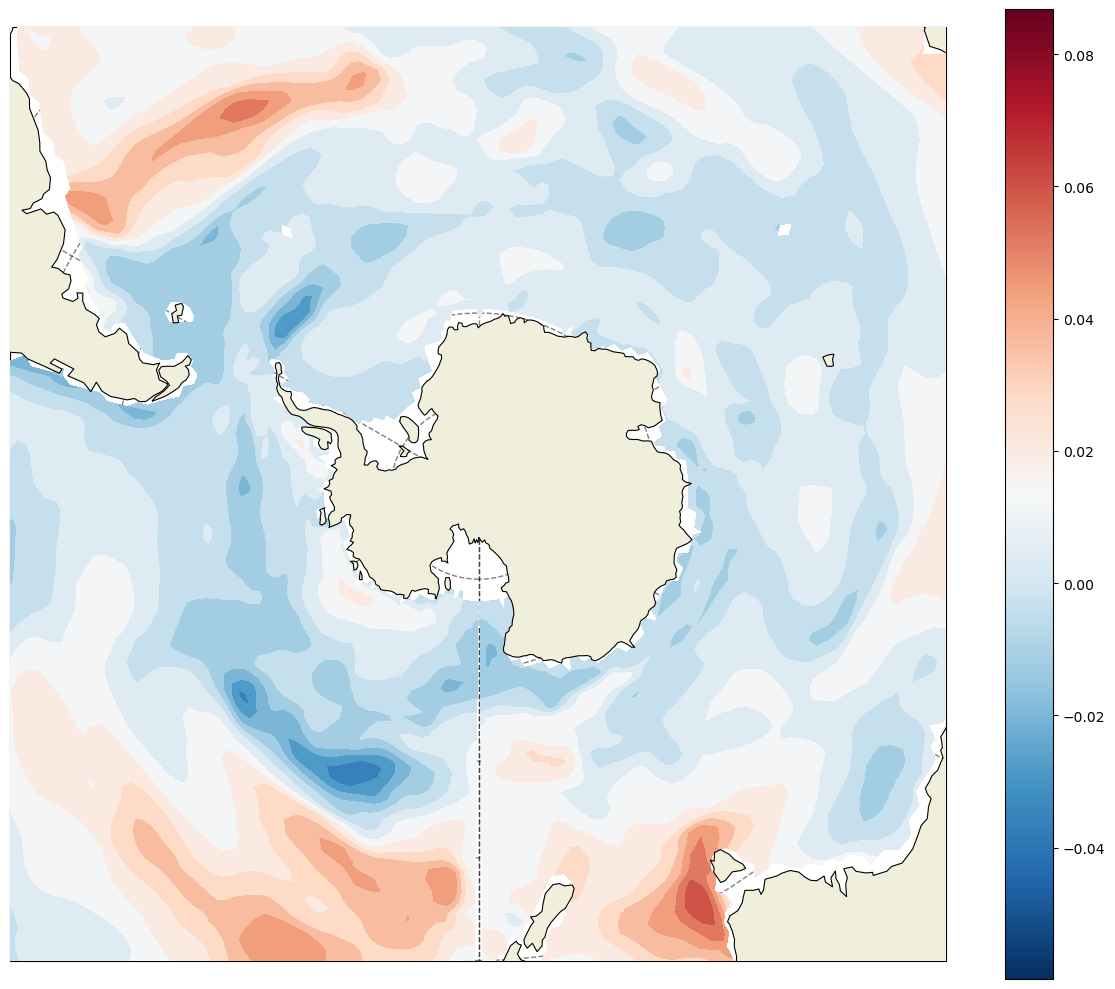

In [33]:
#15. Plot the temperature trend with the new trend calculation
fig  = plt.figure(figsize=(12, 10))
nrow = 1;ncol=1;a=1
ca   = ecco.plot_proj_to_latlon_grid(all_t.XC, all_t.YC, trend, projection_type='stereo',plot_type = 'contourf',dx=1, dy=1,lat_lim=-40,colormap=colorm,show_colorbar=True,show_coastline=True,show_tile_labels = montitles[a],subplot_grid=[nrow, ncol, a]);
plt.tight_layout()
